<a href="https://colab.research.google.com/github/vimesh630/Revenue_Forecasting/blob/main/Random_Forest_for_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Import Required Libraries

In [6]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#2. Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#3. Load Training and Test Data

In [10]:
train_path='/content/drive/MyDrive/VERGER/Revenue_Forecasting/train_forecast_data.csv'
test_path='/content/drive/MyDrive/VERGER/Revenue_Forecasting/test_forecast_data.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

#3. Select Features

In [11]:
features=['Account', 'Product', 'Type', 'Lag_Qty_1', 'Lag_Qty_2', 'Lag_Rev_1', 'Lag_Rev_2',
            'Rolling_Qty_3', 'Rolling_Rev_3']

target_quantity='Forecast_Quantity'
target_revenue='Forecast_Revenue'

#4. Drop Rows with Missing Features

In [12]:
train_df = train_df.dropna(subset=features + [target_quantity, target_revenue])
test_df = test_df.dropna(subset=features + [target_quantity, target_revenue])

X_train = train_df[features]
X_test = test_df[features]

y_train_qty = train_df[target_quantity]
y_test_qty = test_df[target_quantity]

y_train_rev = train_df[target_revenue]
y_test_rev = test_df[target_revenue]

#5. Define Preprocessing for Categorical Columns

In [13]:
categorical_features = ['Account', 'Product', 'Type']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Keep numerical columns
)

#6. Build Pipelines for Each Model

In [14]:
def build_model():
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ])

model_qty = build_model()
model_rev = build_model()

#7. Train Models

In [15]:
model_qty.fit(X_train, y_train_qty)
model_rev.fit(X_train, y_train_rev)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Account', 'Product',
                                                   'Type'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

#8. Predict and Evaluate

In [17]:
from sklearn.metrics import r2_score

def evaluate_model(model, X, y_true, label=""):
    y_pred = model.predict(X)
    rmse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {label} Forecasting Results:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE : {mae:.2f}")
    print(f"  R²  : {r2:.4f}")
    return y_pred

# Quantity Evaluation
y_pred_qty = evaluate_model(model_qty, X_test, y_test_qty, "Quantity")

# Revenue Evaluation
y_pred_rev = evaluate_model(model_rev, X_test, y_test_rev, "Revenue")


📊 Quantity Forecasting Results:
  RMSE: 83625.98
  MAE : 162.95
  R²  : 0.3790

📊 Revenue Forecasting Results:
  RMSE: 799118173.95
  MAE : 11286.30
  R²  : -0.1268


#9. Feature Importance

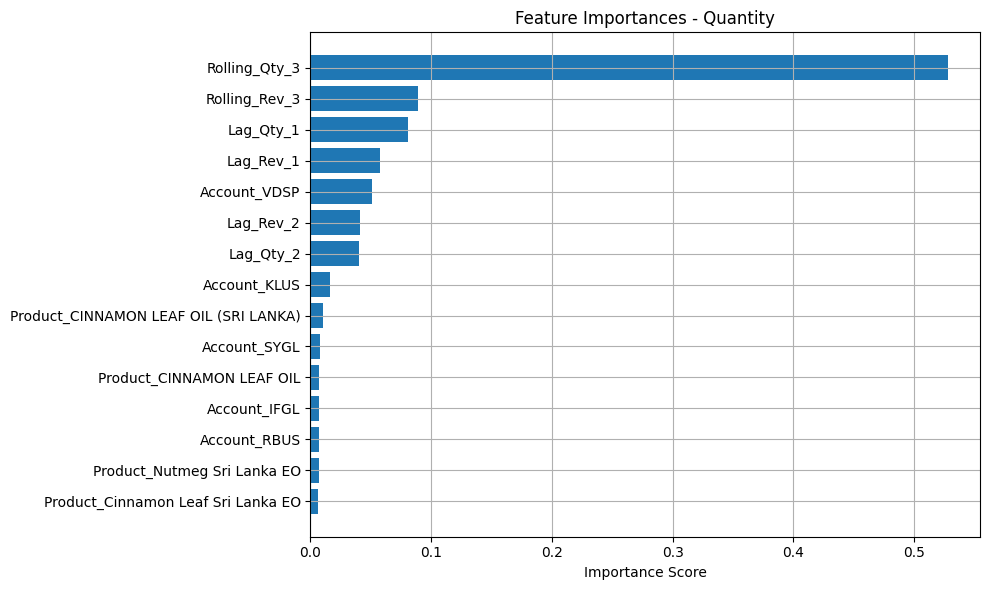

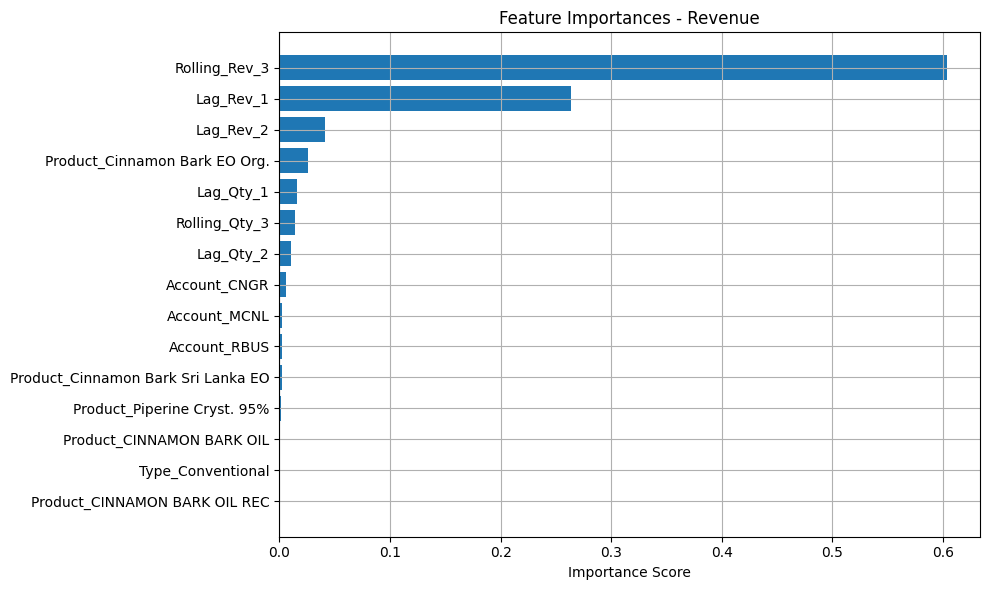

In [18]:
def plot_feature_importances(model, feature_names, title):
    # Get feature names after one-hot encoding
    encoded_cat = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
    all_feature_names = np.concatenate([encoded_cat, features[3:]])  # append numerical features
    importances = model.named_steps['regressor'].feature_importances_

    # Sort
    sorted_idx = np.argsort(importances)[-15:]  # top 15
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [all_feature_names[i] for i in sorted_idx])
    plt.title(f'Feature Importances - {title}')
    plt.xlabel('Importance Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_feature_importances(model_qty, features, "Quantity")
plot_feature_importances(model_rev, features, "Revenue")

#10. Plot Prediction vs Actual

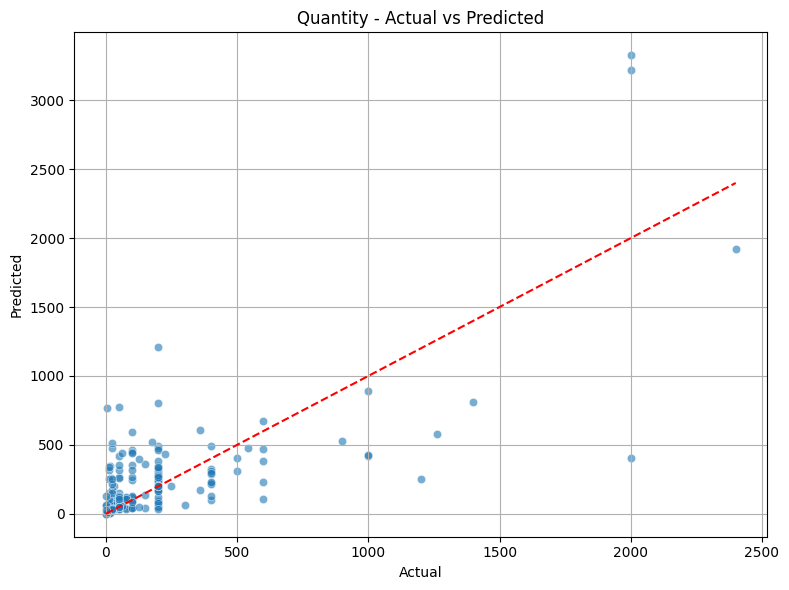

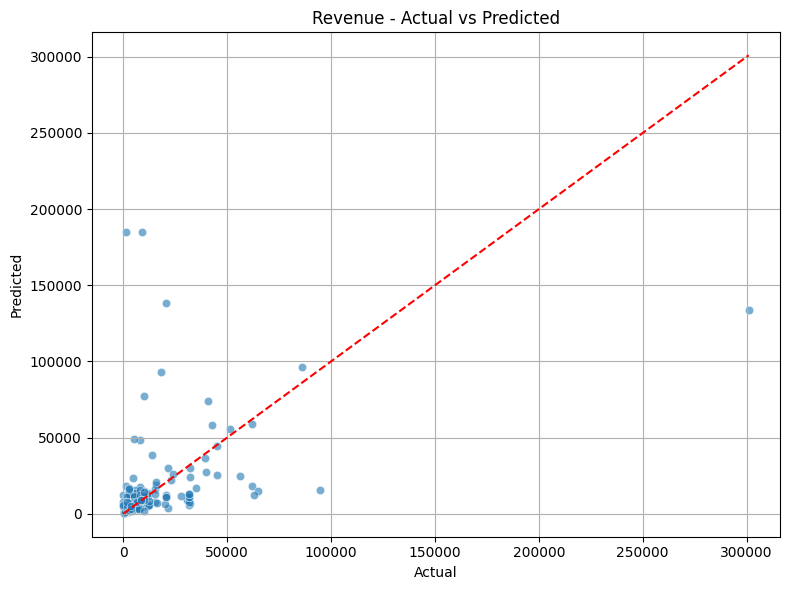

In [20]:
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{title} - Actual vs Predicted')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_predictions(y_test_qty, y_pred_qty, "Quantity")
plot_predictions(y_test_rev, y_pred_rev, "Revenue")